# EE4211 Project

## Question 1

Group name:We4

Group members: Liu Tianshu, Nie Hongtuo, Pan Jie, Zhang Chenxi

### Question 1.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')

First let's get the number of houses.

In [2]:
grouped = df.groupby(['dataid'])
len(grouped)

157

or

In [3]:
df.dataid.value_counts().size

157

We have gas flow meters installed in 157 houses.
Now we can find the anomaly samples in the data.

In [4]:
defect_id = []
for key,group in grouped:
    val = group.meter_value.values
    diff = val[1:] - val[:-1]
    defect_time = np.where(diff < 0)[0]
    if len(defect_time):
        defect_id.append(key)
        defect_time = group.localminute.values[defect_time + 1]
        print('The glitches of gas meter No.', key, 'happened in the moments below:')
        print(defect_time, '\n')

The glitches of gas meter No. 35 happened in the moments below:
['2015-10-20 09:00:12-05'] 

The glitches of gas meter No. 77 happened in the moments below:
['2015-10-20 20:20:55-05'] 

The glitches of gas meter No. 94 happened in the moments below:
['2015-11-01 01:11:10-06' '2015-11-01 01:17:53-06'
 '2015-11-01 01:23:12-06' '2016-01-16 10:23:43.197562-06'
 '2016-01-18 11:19:47.220413-06' '2016-01-18 11:26:52.211985-06'] 

The glitches of gas meter No. 483 happened in the moments below:
['2015-10-21 00:18:54-05'] 

The glitches of gas meter No. 484 happened in the moments below:
['2015-11-01 01:18:29-06' '2015-11-01 01:34:43-06'
 '2015-11-01 01:40:00-06' '2015-11-01 01:44:34-06'
 '2015-11-01 01:48:31-06' '2015-11-01 01:55:28-06'
 '2016-03-05 00:01:58.770374-06' '2016-03-05 01:43:22.133007-06'
 '2016-03-05 01:57:57.625975-06'] 

The glitches of gas meter No. 1042 happened in the moments below:
['2015-10-07 14:32:08-05'] 

The glitches of gas meter No. 1086 happened in the moments below:

In [10]:
print('The ID of the', len(defect_id), 'defective meters are:')
print(defect_id)

The ID of the 43 defective meters are:
[35, 77, 94, 483, 484, 1042, 1086, 1185, 1507, 1556, 1718, 1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193, 4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017, 7030, 7117, 7739, 7794, 7989, 8156, 8890, 9134, 9639, 9982]


43 gas meters have sent values that decreased at some point.
Let's look inside the data series given by a defective meter, for example, gas meter No. 9982.

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]),
 <a list of 11 Text major ticklabel objects>)

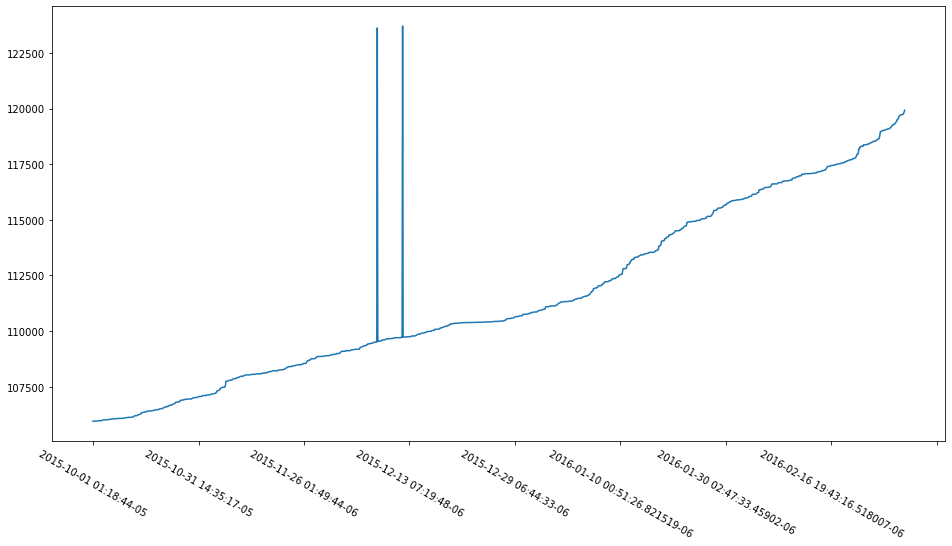

In [11]:
group = grouped.get_group(9982)
t = group.localminute.values
val = group.meter_value.values

s = pd.Series(val, index=t)
s.plot(figsize=(16, 8))
plt.xticks(rotation=-30)

### Question 1.2
Generate hourly readings from the raw data. Select one month from the 6-month
study interval and plot the hourly readings (time-series) for that month. Hint: You
will have to decide what to do if there are no readings for a certain hour.